# Assignment 3: Time-Series Data


**Download the Jena Climate data zip file from the AWS S3 Bucket URL**

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip


--2025-11-03 01:46:04--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.108.216, 54.231.228.200, 52.217.167.144, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.108.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.0MB/s    in 0.6s    

2025-11-03 01:46:05 (21.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



**Extracting a Zip File in Google Colab**



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


## Analyzing the Data of the Jena Weather Dataset






In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("All Variables:", num_variables)
num_rows = len(lines)
print("All Rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
All Variables: 15
All Rows: 420451


## Parse the data

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

## Temperature timeseries Plot





Text(0, 0.5, 'Temperature')

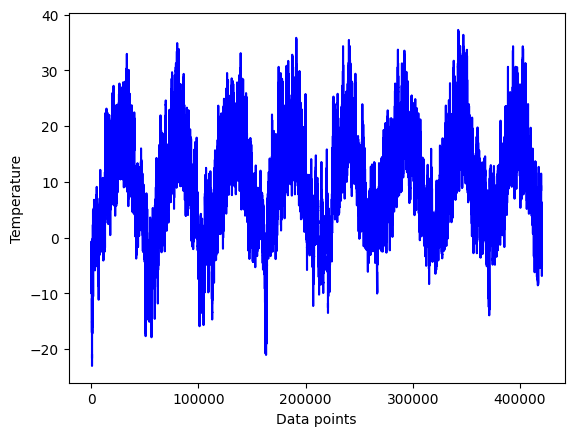

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature, color='blue')
plt.xlabel('Data points')
plt.ylabel('Temperature')

## Plotting the temperature timeseries for first ten days



It seems that the data is recorded every 10 minutes, giving us 24 × 6 = 144 24×6=144 data points per day. Therefore, data collected over 10 days will contain a total of 1,440 data points.

Text(0, 0.5, 'Temperature')

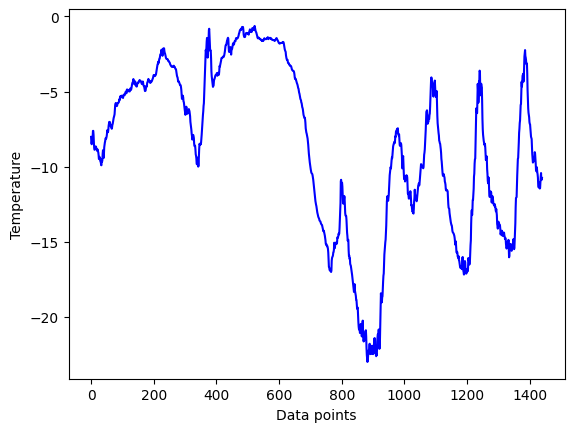

In [8]:
plt.plot(range(1440), temperature[:1440], color='blue')
plt.xlabel('Data points')
plt.ylabel('Temperature')

## Splitting Dataset into Train, Validation, and Test Sets



We'll split the data as follows: 50% for training, 25% for validation, and the remaining 25% for testing.



In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("number_of_train_spls:", num_train_samples)
print("number_of_validation_spls:", num_val_samples)
print("number_of_test_spls:", num_test_samples)

number_of_train_spls: 210225
number_of_validation_spls: 105112
number_of_test_spls: 105114


## Preparing the data


Normalizing the data: Vectorization is unnecessary since the data is already in numerical form. However, it is recommended to standardize all variables because their scales differ — for instance, temperature ranges from -20 to +30, while pressure is measured in millibars.

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Creating datasets for training, validation, and testing is essential because the dataset contains many duplicate samples. Allocating memory explicitly for each sample would therefore be inefficient. Instead, we will generate the samples in real time.

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

## Inspecting the output of one of our datasets

In [13]:
for samples, targets in train_dataset:
    print("shape of the sample:", samples.shape)
    print("shape of the targets:", targets.shape)
    break

shape of the sample: (256, 120, 14)
shape of the targets: (256,)


## A simple, rule-based (non-machine learning) baseline

Calculating the baseline MAE — The evaluate_naive_method function provides a reference point for evaluating the performance of a simple forecasting approach, which predicts the next value in the sequence using the last observed value from the input data.



In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

mae_validation = evaluate_naive_method(val_dataset)
mae_test = evaluate_naive_method(test_dataset)

print(f"MAE_Validation: {mae_validation:.2f}")
print(f"MAE_Test: {mae_test:.2f}")

MAE_Validation: 2.44
MAE_Test: 2.62


A reasonable baseline method is to predict that the temperature over the next 24 hours will remain the same as it is now. Using this simple baseline, the validation MAE (Mean Absolute Error) is 2.44°C, and the test MAE is 2.62°C. In other words, assuming the temperature stays constant results in an average error of about 2.5°C.

## Dense Layer-Basic Machine learning Model


In [23]:
from tensorflow import keras

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)
x = keras.layers.Dense(16, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10,
                    validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - loss: 19.4379 - mae: 3.3249 - val_loss: 10.1818 - val_mae: 2.5227
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 9.4171 - mae: 2.4147 - val_loss: 10.3672 - val_mae: 2.5442
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 8.5454 - mae: 2.3055 - val_loss: 9.8958 - val_mae: 2.4795
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 8.0325 - mae: 2.2329 - val_loss: 10.9685 - val_mae: 2.6242
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 7.6432 - mae: 2.1795 - val_loss: 10.7895 - val_mae: 2.6001
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - loss: 7.3204 - mae: 2.1334 - val_loss: 11.8743 - val_mae: 2.7226


In [24]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 10.9407 - mae: 2.6061
Test_MAE: 2.62


### Results Plot



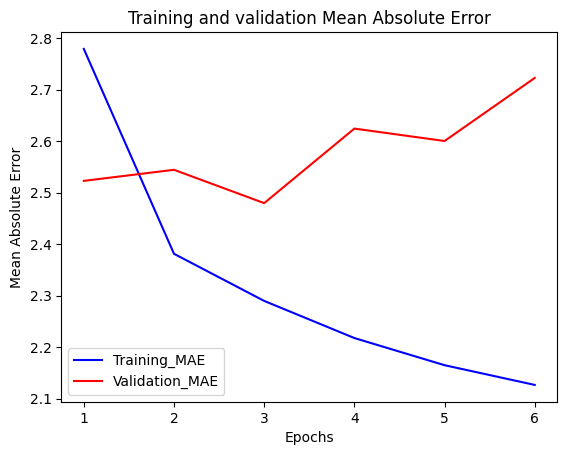

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

## 1D convolutional model


In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Conv1D(8, 24, activation="relu")(inputs)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Conv1D(8, 12, activation="relu")(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Conv1D(8, 6, activation="relu")(x)
x = keras.layers.GlobalAveragePooling1D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - loss: 30.9292 - mae: 4.2928 - val_loss: 15.9308 - val_mae: 3.1406
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - loss: 18.1595 - mae: 3.3257 - val_loss: 17.7757 - val_mae: 3.3869
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 14.1356 - mae: 2.9722 - val_loss: 13.6008 - val_mae: 2.9223
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 13.0444 - mae: 2.8486 - val_loss: 14.8533 - val_mae: 3.0191
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 12.2460 - mae: 2.7565 - val_loss: 14.8840 - val_mae: 3.0319
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 11.7256 - mae: 2.6981 - val_loss: 14.0074 - val_mae: 2.9499
405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 15.2825 - mae: 3.1023
Test_MAE: 3.11


### Results Plot



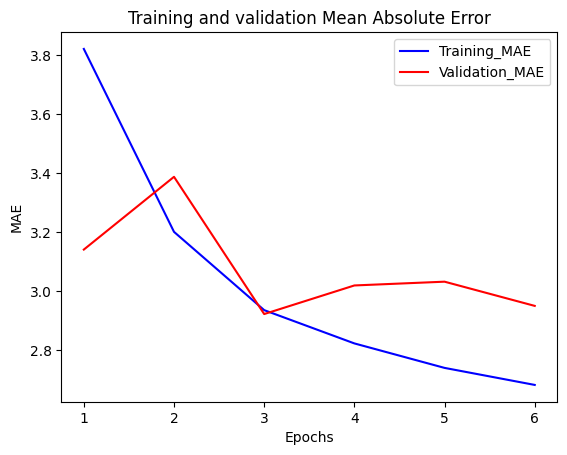

In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

It appears that the convolutional model performed worse than both the simple baseline and the dense model. This may be due to two key reasons:

*   The assumption of translation invariance does not hold well for weather data.
*   Temporal order is crucial: recent data is far more informative for predicting the next day's temperature than data from several days ago. A 1D convolutional neural network struggles to effectively capture this important temporal dependency.

# RNN

## A layer of an RNN capable of handling any length of sequence


In [32]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
x = keras.layers.SimpleRNN(16)(inputs)
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - loss: 82.3601 - mae: 6.9735 - val_loss: 13.6304 - val_mae: 2.7488
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 64ms/step - loss: 12.4105 - mae: 2.7143 - val_loss: 9.3562 - val_mae: 2.3671
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 10.5720 - mae: 2.5363 - val_loss: 9.7388 - val_mae: 2.3815
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 10.3811 - mae: 2.5112 - val_loss: 9.0239 - val_mae: 2.3358
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 10.2588 - mae: 2.4957 - val_loss: 8.9624 - val_mae: 2.3318
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 10.1345 - mae: 2.4825 - val_loss: 8.9858 - val_mae: 2.3345
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - loss: 10.0813 - mae: 2.4766 - val_loss: 9.0253 - val_mae: 2.3407
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 66ms/step - loss: 10.0335 - mae: 2.4699 - val_loss: 8.9492 - val_mae: 2.3283
Epoch 9/10
819/819 ━━━━━━━━━━━━

### Results Plot

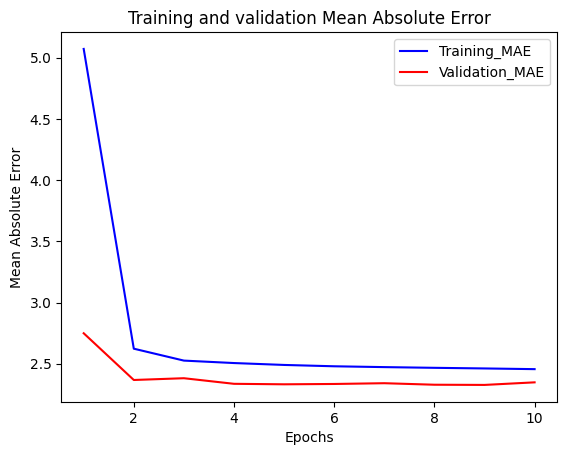

In [33]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

### Stacking RNN layers using simple RNN


In [34]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
x = keras.layers.SimpleRNN(16, return_sequences=True)(x)
x = keras.layers.SimpleRNN(16)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 64s 74ms/step - loss: 62.0814 - mae: 5.9343 - val_loss: 11.8628 - val_mae: 2.5936
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 59s 71ms/step - loss: 11.6780 - mae: 2.6413 - val_loss: 9.3554 - val_mae: 2.3714
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 59s 71ms/step - loss: 10.2505 - mae: 2.4947 - val_loss: 8.9420 - val_mae: 2.3178
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 74ms/step - loss: 9.8570 - mae: 2.4453 - val_loss: 8.9780 - val_mae: 2.3262
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 62s 75ms/step - loss: 9.6090 - mae: 2.4130 - val_loss: 9.3567 - val_mae: 2.3900
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 9.4106 - mae: 2.3877 - val_loss: 9.1306 - val_mae: 2.3446
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 10.4785 - mae: 2.5176
Test_MAE: 2.52


### Results Plot

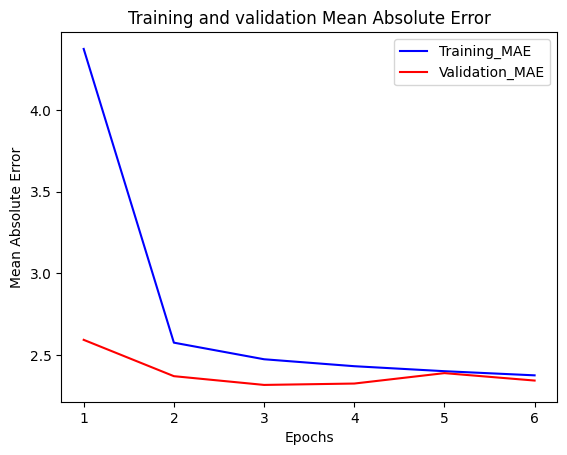

In [35]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

### GRU (Gated Recurrent Unit)-Simple Method


In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.GRU(16)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - loss: 81.4954 - mae: 6.9046 - val_loss: 13.2629 - val_mae: 2.7256
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 66ms/step - loss: 11.6229 - mae: 2.6324 - val_loss: 9.9577 - val_mae: 2.4228
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 9.7157 - mae: 2.4324 - val_loss: 10.0186 - val_mae: 2.4160
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - loss: 9.2741 - mae: 2.3710 - val_loss: 10.2293 - val_mae: 2.4337
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 9.0314 - mae: 2.3383 - val_loss: 9.6683 - val_mae: 2.3845
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 8.8591 - mae: 2.3166 - val_loss: 10.2034 - val_mae: 2.4287
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 8.6961 - mae: 2.2950 - val_loss: 10.0106 - val_mae: 2.4139
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 8.5741 - mae: 2.2792 - val_loss: 10.0030 - val_mae: 2.4164
405/405 ━━━━━━━━━━━━━━━━━━━━ 15s

### Results Plot

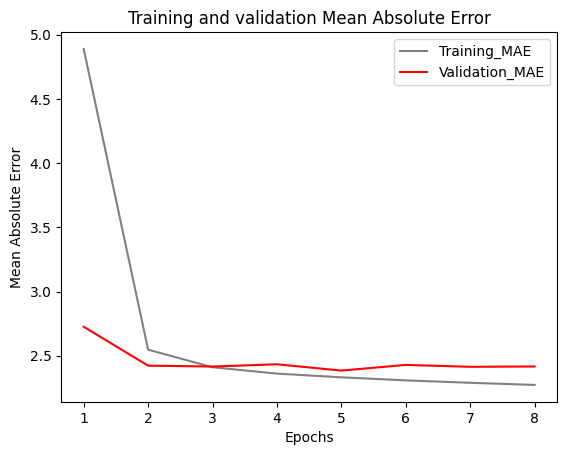

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

# LSTM(Long Short-Term Memory )


## LSTM-Simple

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 68.0540 - mae: 6.2678 - val_loss: 12.2950 - val_mae: 2.6702
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 11.7207 - mae: 2.6456 - val_loss: 9.9761 - val_mae: 2.4503
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 9.7455 - mae: 2.4185 - val_loss: 10.4789 - val_mae: 2.4694
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 9.0601 - mae: 2.3348 - val_loss: 10.0838 - val_mae: 2.4324
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 8.6395 - mae: 2.2826 - val_loss: 10.1040 - val_mae: 2.4558
405/405 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 10.9278 - mae: 2.5764
Test_MAE: 2.59


### Results Plot

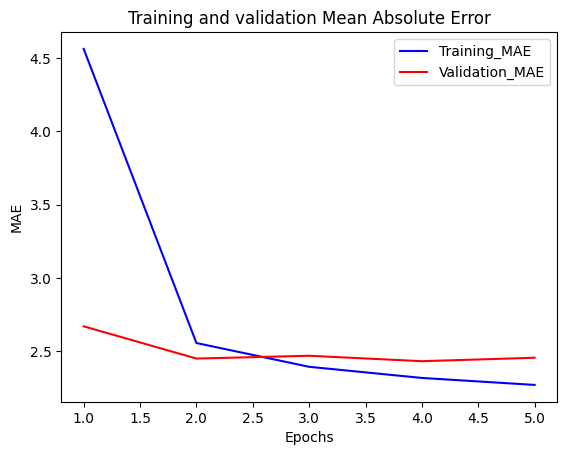

In [40]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM(Dropout Regularization)

In [41]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 317s 382ms/step - loss: 74.4114 - mae: 6.6541 - val_loss: 13.3169 - val_mae: 2.7503
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 312s 381ms/step - loss: 21.7146 - mae: 3.5586 - val_loss: 10.2575 - val_mae: 2.4885
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 312s 380ms/step - loss: 19.0088 - mae: 3.3542 - val_loss: 9.5793 - val_mae: 2.4131
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 313s 381ms/step - loss: 17.9670 - mae: 3.2647 - val_loss: 9.4241 - val_mae: 2.3961
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 310s 378ms/step - loss: 17.2803 - mae: 3.2061 - val_loss: 9.4101 - val_mae: 2.3921
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 309s 377ms/step - loss: 16.6037 - mae: 3.1456 - val_loss: 9.4290 - val_mae: 2.3898
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 310s 378ms/step - loss: 16.4154 - mae: 3.1198 - val_loss: 9.3122 - val_mae: 2.3752
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 309s 377ms/step - loss: 15.8465 - mae: 3.0735 - val_loss: 9.4720 - val_mae: 2.3936
Epoch 9/10
819

### Results Plot

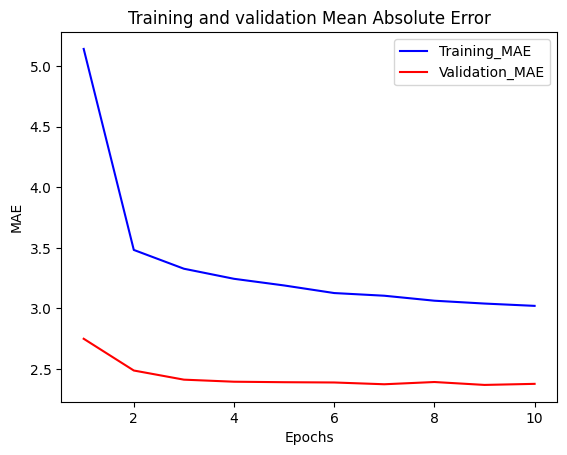

In [42]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM - Stacked(16 units)

In [43]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16, return_sequences=True)(inputs)
x = keras.layers.LSTM(16)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - loss: 62.0370 - mae: 5.9039 - val_loss: 11.6312 - val_mae: 2.5855
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 10.6896 - mae: 2.5278 - val_loss: 9.5271 - val_mae: 2.3974
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - loss: 8.9058 - mae: 2.3295 - val_loss: 9.9462 - val_mae: 2.4520
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - loss: 8.1870 - mae: 2.2361 - val_loss: 9.4338 - val_mae: 2.3920
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 7.6704 - mae: 2.1622 - val_loss: 9.5547 - val_mae: 2.3993
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 7.2780 - mae: 2.1014 - val_loss: 10.0239 - val_mae: 2.4817
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 6.9044 - mae: 2.0455 - val_loss: 10.0639 - val_mae: 2.4625
405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 10.8405 - mae: 2.5793
Test_MAE: 2.59


### Results Plot

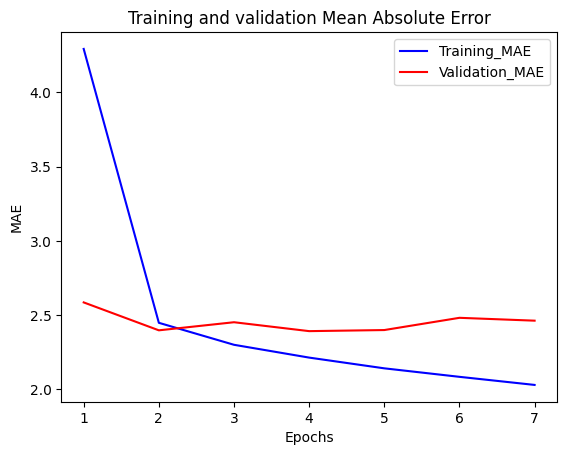

In [44]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM - Stacked(32 units)

In [45]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(32, return_sequences=True)(inputs)
x = keras.layers.LSTM(32)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - loss: 42.4507 - mae: 4.7168 - val_loss: 9.9231 - val_mae: 2.4504
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - loss: 8.4139 - mae: 2.2540 - val_loss: 10.2850 - val_mae: 2.4934
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 6.6497 - mae: 2.0014 - val_loss: 10.9238 - val_mae: 2.5882
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 5.5598 - mae: 1.8276 - val_loss: 11.6448 - val_mae: 2.6953
405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 11.6571 - mae: 2.6632
Test_MAE: 2.67


### Results Plot

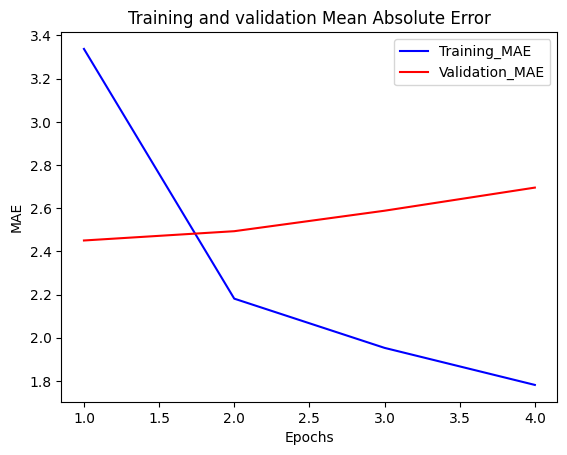

In [46]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM - Stacked(8 units)

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(8, return_sequences=True)(inputs)
x = keras.layers.LSTM(8)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - loss: 95.9269 - mae: 7.7521 - val_loss: 33.7593 - val_mae: 4.3291
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - loss: 26.2814 - mae: 3.8026 - val_loss: 13.4134 - val_mae: 2.7514
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 12.1022 - mae: 2.6901 - val_loss: 11.8127 - val_mae: 2.5756
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - loss: 10.1550 - mae: 2.4961 - val_loss: 10.7336 - val_mae: 2.4801
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - loss: 9.7377 - mae: 2.4493 - val_loss: 10.1536 - val_mae: 2.4397
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 9.5160 - mae: 2.4177 - val_loss: 9.6893 - val_mae: 2.4040
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step - loss: 9.3148 - mae: 2.3919 - val_loss: 9.3486 - val_mae: 2.3702
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 9.1958 - mae: 2.3767 - val_loss: 9.6548 - val_mae: 2.3923
Epoch 9/10
819/819 ━━━━━━━━━━━━

### Results Plot

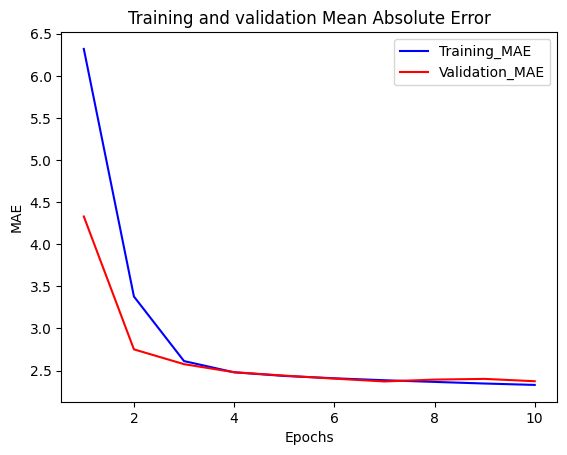

In [48]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM(dropout-regularized and stacked model)

In [50]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = keras.layers.LSTM(8, recurrent_dropout=0.5)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 647s 784ms/step - loss: 102.0304 - mae: 8.0470 - val_loss: 35.6366 - val_mae: 4.4250
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 638s 779ms/step - loss: 36.2914 - mae: 4.4908 - val_loss: 14.4942 - val_mae: 2.8465
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 632s 771ms/step - loss: 25.2458 - mae: 3.7903 - val_loss: 11.0771 - val_mae: 2.5420
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 636s 776ms/step - loss: 22.9299 - mae: 3.6351 - val_loss: 10.4993 - val_mae: 2.4949
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 637s 778ms/step - loss: 21.4523 - mae: 3.5172 - val_loss: 10.1641 - val_mae: 2.4646
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 638s 778ms/step - loss: 20.5709 - mae: 3.4486 - val_loss: 10.8506 - val_mae: 2.5613
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 631s 771ms/step - loss: 19.7417 - mae: 3.3776 - val_loss: 9.9116 - val_mae: 2.4463
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 632s 771ms/step - loss: 19.0786 - mae: 3.3238 - val_loss: 9.9807 - val_mae: 2.4597
Epoch 9/1

### Results Plot

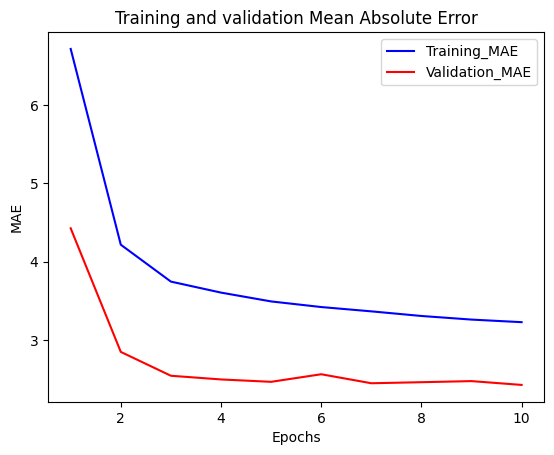

In [51]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM(Bidirectional )


In [52]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Bidirectional(keras.layers.LSTM(16))(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - loss: 55.8486 - mae: 5.4878 - val_loss: 10.6808 - val_mae: 2.5342
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 9.7039 - mae: 2.4372 - val_loss: 10.2564 - val_mae: 2.4791
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 8.5994 - mae: 2.2860 - val_loss: 10.1123 - val_mae: 2.4747
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 62ms/step - loss: 7.9960 - mae: 2.2035 - val_loss: 10.2412 - val_mae: 2.4847
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 7.5726 - mae: 2.1482 - val_loss: 10.8490 - val_mae: 2.5537
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 7.2782 - mae: 2.1108 - val_loss: 10.2334 - val_mae: 2.4953
405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 10.8854 - mae: 2.6005
Test_MAE: 2.61


### Results Plot

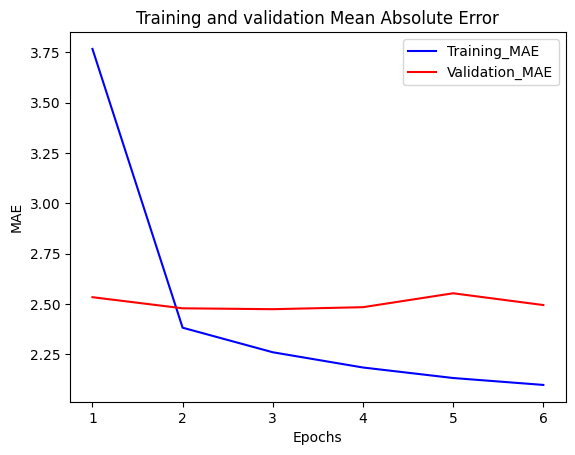

In [53]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM and 1D Convnets


In [54]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Conv1D(64, 3, activation='relu')(inputs)
x = keras.layers.MaxPooling1D(3)(x)
x = keras.layers.Conv1D(128, 3, activation='relu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = keras.layers.LSTM(16)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - loss: 77.3268 - mae: 6.7933 - val_loss: 26.8857 - val_mae: 3.9820
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 19.9416 - mae: 3.4209 - val_loss: 21.6459 - val_mae: 3.6916
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 15.0203 - mae: 3.0142 - val_loss: 25.5093 - val_mae: 3.9405
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 13.0493 - mae: 2.8038 - val_loss: 22.1180 - val_mae: 3.7302
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 11.7139 - mae: 2.6506 - val_loss: 23.7749 - val_mae: 3.9083
405/405 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 23.1754 - mae: 3.8464
Test_MAE: 3.86


### Results Plot

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### 14 models were constructed : Here are the specifics:

*   Model 1: common-sense, non-machine-learning baseline
*   Model 2: A basic machine-learning model
*   Model 3: 1D convolutional model
*   Model 4: Simple RNN layer that can process sequences of any length
*   Model 5: Stacking RNN layers using simple RNN
*   Model 6: GRU (Gated Recurrent Unit)-Simple Method
*   Model 7: LSTM-Simple
*   Model 8: LSTM(dropout Regularization)
*   Model 9: LSTM Stacked(16 units)
*   Model 10: LSTM Stacked(32 units)
*   Model 11: LSTM Stacked(8 units)
*   Model 12: LSTM(dropout-regularized and stacked)
*   Model 13: LSTM(Bidirectional )
*   Model 14: LSTM and 1D Convnets

# Evaluation of  MAE Evaluation

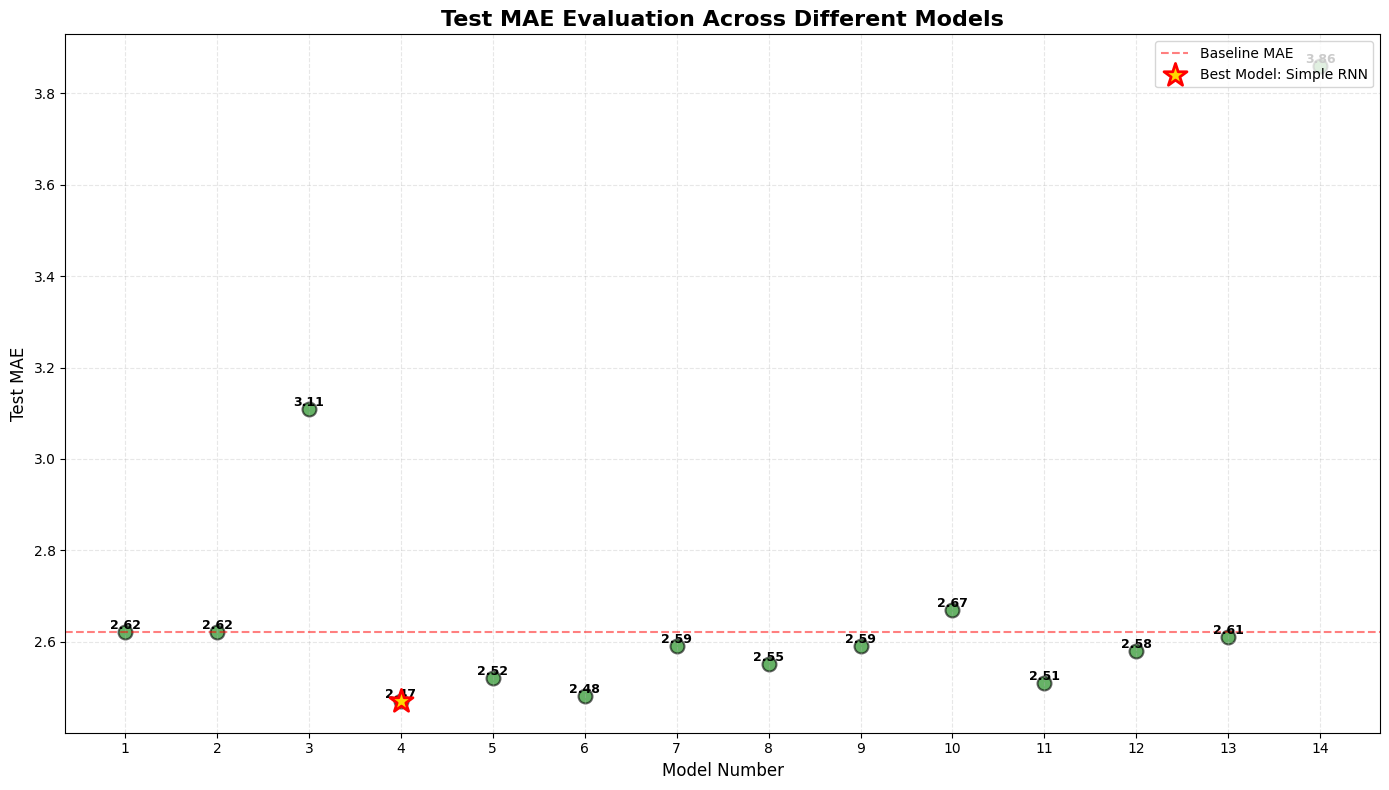


MODEL PERFORMANCE SUMMARY (Test MAE)
 1. Naive Baseline       : 2.62
 2. Dense Layer          : 2.62
 3. 1D Conv              : 3.11
 4. Simple RNN           : 2.47 * BEST
 5. Stacked RNN          : 2.52
 6. GRU                  : 2.48
 7. LSTM Simple          : 2.59
 8. LSTM Dropout         : 2.55
 9. LSTM Stack16         : 2.59
10. LSTM Stack32         : 2.67
11. LSTM Stack8          : 2.51
12. LSTM Drop+Stack      : 2.58
13. LSTM Bidir           : 2.61
14. LSTM+Conv            : 3.86
Best Model: Simple RNN with Test MAE = 2.47
Worst Model: LSTM+Conv with Test MAE = 3.86
Average Test MAE: 2.70


In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and their Test MAE values
Models = [
    "Naive Baseline",
    "Dense Layer",
    "1D Conv",
    "Simple RNN",
    "Stacked RNN",
    "GRU",
    "LSTM Simple",
    "LSTM Dropout",
    "LSTM Stack16",
    "LSTM Stack32",
    "LSTM Stack8",
    "LSTM Drop+Stack",
    "LSTM Bidir",
    "LSTM+Conv"
]

# Test MAE values
Test_MAE = [2.62, 2.62, 3.11, 2.47, 2.52, 2.48, 2.59, 2.55, 2.59, 2.67, 2.51, 2.58, 2.61, 3.86]

# Create model numbers for x-axis
Model_Numbers = list(range(1, len(Models) + 1))

##**Evaluation of MAE Evaluation**##
plt.figure(figsize=(14, 8))
plt.scatter(Model_Numbers, Test_MAE, color="green", s=100, alpha=0.6, edgecolors='black', linewidth=1.5)
plt.title("Test MAE Evaluation Across Different Models", fontsize=16, fontweight='bold')
plt.xlabel("Model Number", fontsize=12)
plt.ylabel("Test MAE", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Add value labels on points
for (xi, yi) in zip(Model_Numbers, Test_MAE):
    plt.text(xi, yi, f'{yi:.2f}', va='bottom', ha='center', fontsize=9, fontweight='bold')

# Set x-axis ticks with model names
plt.xticks(Model_Numbers, Model_Numbers, rotation=0)

# Add a horizontal line for the baseline
plt.axhline(y=2.62, color='red', linestyle='--', alpha=0.5, label='Baseline MAE')

# Highlight the best model
best_idx = Test_MAE.index(min(Test_MAE))
plt.scatter(Model_Numbers[best_idx], Test_MAE[best_idx], color='gold', s=300,
            marker='*', edgecolors='red', linewidth=2, zorder=5, label=f'Best Model: {Models[best_idx]}')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY (Test MAE)")
print("="*60)
for i, (model, mae) in enumerate(zip(Models, Test_MAE), 1):
    status = " * BEST" if mae == min(Test_MAE) else ""
    print(f"{i:2d}. {model:20s} : {mae:.2f}{status}")
print("="*60)
print(f"Best Model: {Models[best_idx]} with Test MAE = {Test_MAE[best_idx]:.2f}")
print(f"Worst Model: {Models[Test_MAE.index(max(Test_MAE))]} with Test MAE = {max(Test_MAE):.2f}")
print(f"Average Test MAE: {np.mean(Test_MAE):.2f}")
print("="*60)